## Face R-FCN Widerface Face Detection - Inspect Trained Model

Code and visualizations to test, debug, and evaluate the Face R-FCN model.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath(".")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from KerasRFCN import Utils
from KerasRFCN import Visualize
from KerasRFCN.Visualize import display_images
import KerasRFCN.Model.Model as modellib
from KerasRFCN import Data_generator
import WiderFace
%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
MODEL_PATH = os.path.join(ROOT_DIR, "logs/widerface20190501T0052/Keras-RFCN_widerface_0013.h5")

Using TensorFlow backend.


In [5]:
def log(text, array=None):
    """Prints a text message. And, optionally, if a Numpy array is provided it
    prints it's shape, min, and max values.
    """
    if array is not None:
        text = text.ljust(25)
        text += ("shape: {:20}  ".format(str(array.shape)))
        if array.size:
            text += ("min: {:10.5f}  max: {:10.5f}".format(array.min(),array.max()))
        else:
            text += ("min: {:10}  max: {:10}".format("",""))
        text += "  {}".format(array.dtype)
    print(text)


## Notebook Preferences

In [2]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in inference mode
TEST_MODE = "inference"

In [3]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.

    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [4]:
# Build validation dataset

dataset = WiderFace.WiderFaceDataset()
dataset.initDB(img_dir='C:/Data/WIDERFACE_Dataset/val/images',
                    annotation_file='C:/Data/WIDERFACE_Dataset/wider_face_split/wider_face_val_bbx_gt.txt')
dataset.prepare()


print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 3225
Classes: ['BG', 'Face']


## Configurations

In [6]:
config = WiderFace.RFCNNConfig()

In [7]:
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
C                              2
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  768
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
K                              3
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MAX_GT_INSTANCES               1000
MEAN_PIXEL                     [123.7 116.8 103.9]
NAME                           WiderFace
NUM_CLASSES                    2
OHEM                           True
OHEM_HARD_EXAMPLES_SIZE        256
POOL_SIZE                  

In [8]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
C                              2
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  768
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
K                              3
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MAX_GT_INSTANCES               1000
MEAN_PIXEL                     [123.7 116.8 103.9]
NAME                           WiderFace
NUM_CLASSES                    2
OHEM                           True
OHEM_HARD_EXAMPLES_SIZE        256
POOL_SIZE                  

## Load Model

In [9]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.RFCN_Model(mode="inference", model_dir=MODEL_DIR,
                              config=config)

# Load weights
print("Loading weights ", MODEL_PATH)
model.load_weights(MODEL_PATH, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Loading weights  D:\UB\Spring19\Biometrics\Project3\FaceRFCN\FaceRFCN\logs/widerface20190501T0052/Keras-RFCN_widerface_0013.h5


## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [10]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox =\
    WiderFace.load_image_gt(dataset, config, image_id)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

image ID: Widerface.1813 (1813) 


In [12]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = Data_generator.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = Utils.apply_box_deltas(
    positive_anchors, target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

target_rpn_match         shape: (261888,)             min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (65472, 4)            min:   -2.41291  max:    3.12500  float64
positive_anchors         shape: (10, 4)               min:  -42.03867  max:  872.00000  float64
negative_anchors         shape: (65462, 4)            min: -362.03867  max: 1322.03867  float64
neutral anchors          shape: (196416, 4)           min: -362.03867  max: 1322.03867  float64
refined_anchors          shape: (10, 4)               min:  192.00000  max:  868.00000  float32


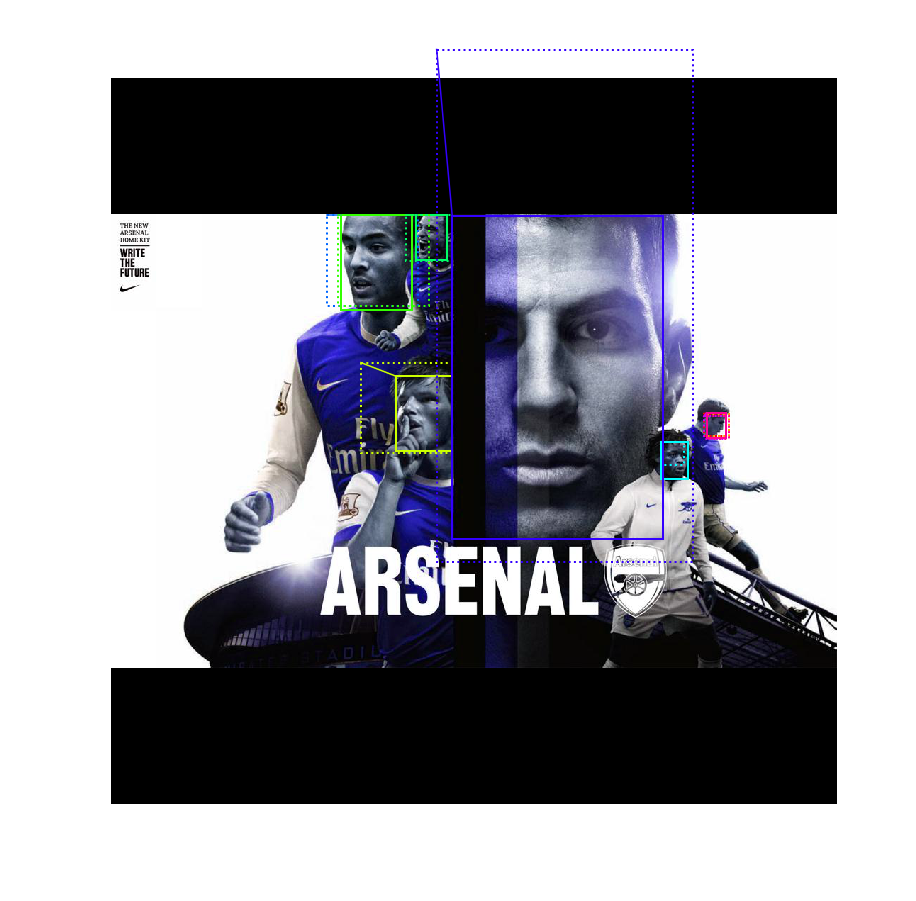

In [13]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
Visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [14]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10001  float32
res4w_out                shape: (1, 64, 64, 1024)     min:    0.00000  max:   20.54118  float32
rpn_bbox                 shape: (1, 261888, 4)        min:  -28.74887  max:   29.80015  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    0.99572  float32


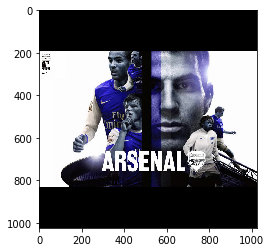

In [15]:
# Input image (normalized)
_ = plt.imshow(Utils.unmold_image(activations["input_image"][0],config))

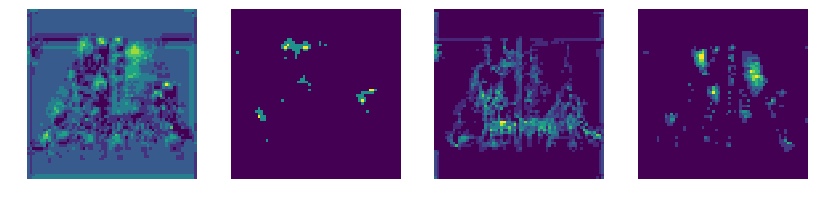

In [16]:
# Backbone feature map
display_images(np.transpose(activations["res4w_out"][0,:,:,:4], [2, 0, 1]))

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [17]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 261888, 2)        min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min: -106.03867  max: 1024.00000  float32
refined_anchors          shape: (1, 6000, 4)          min:   -0.24192  max: 1019.61340  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max: 1019.61340  float32
post_nms_anchor_ix       shape: (644,)                min:    0.00000  max: 5997.00000  int32
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    0.99572  float32


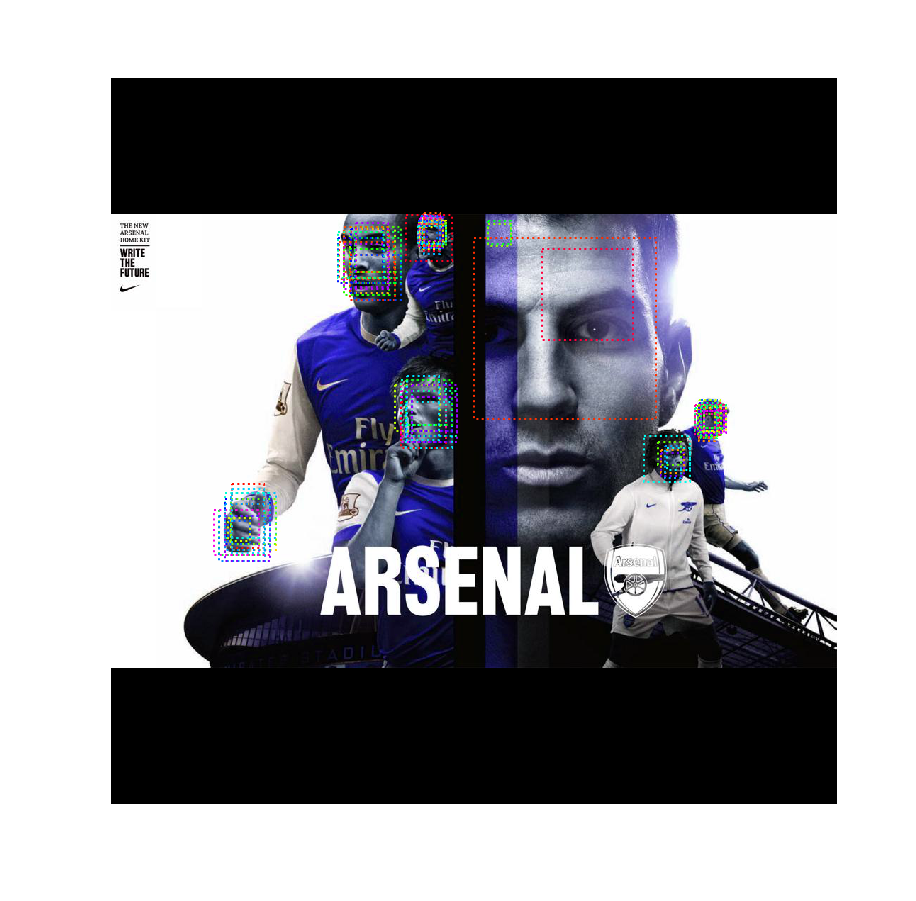

In [18]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
Visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

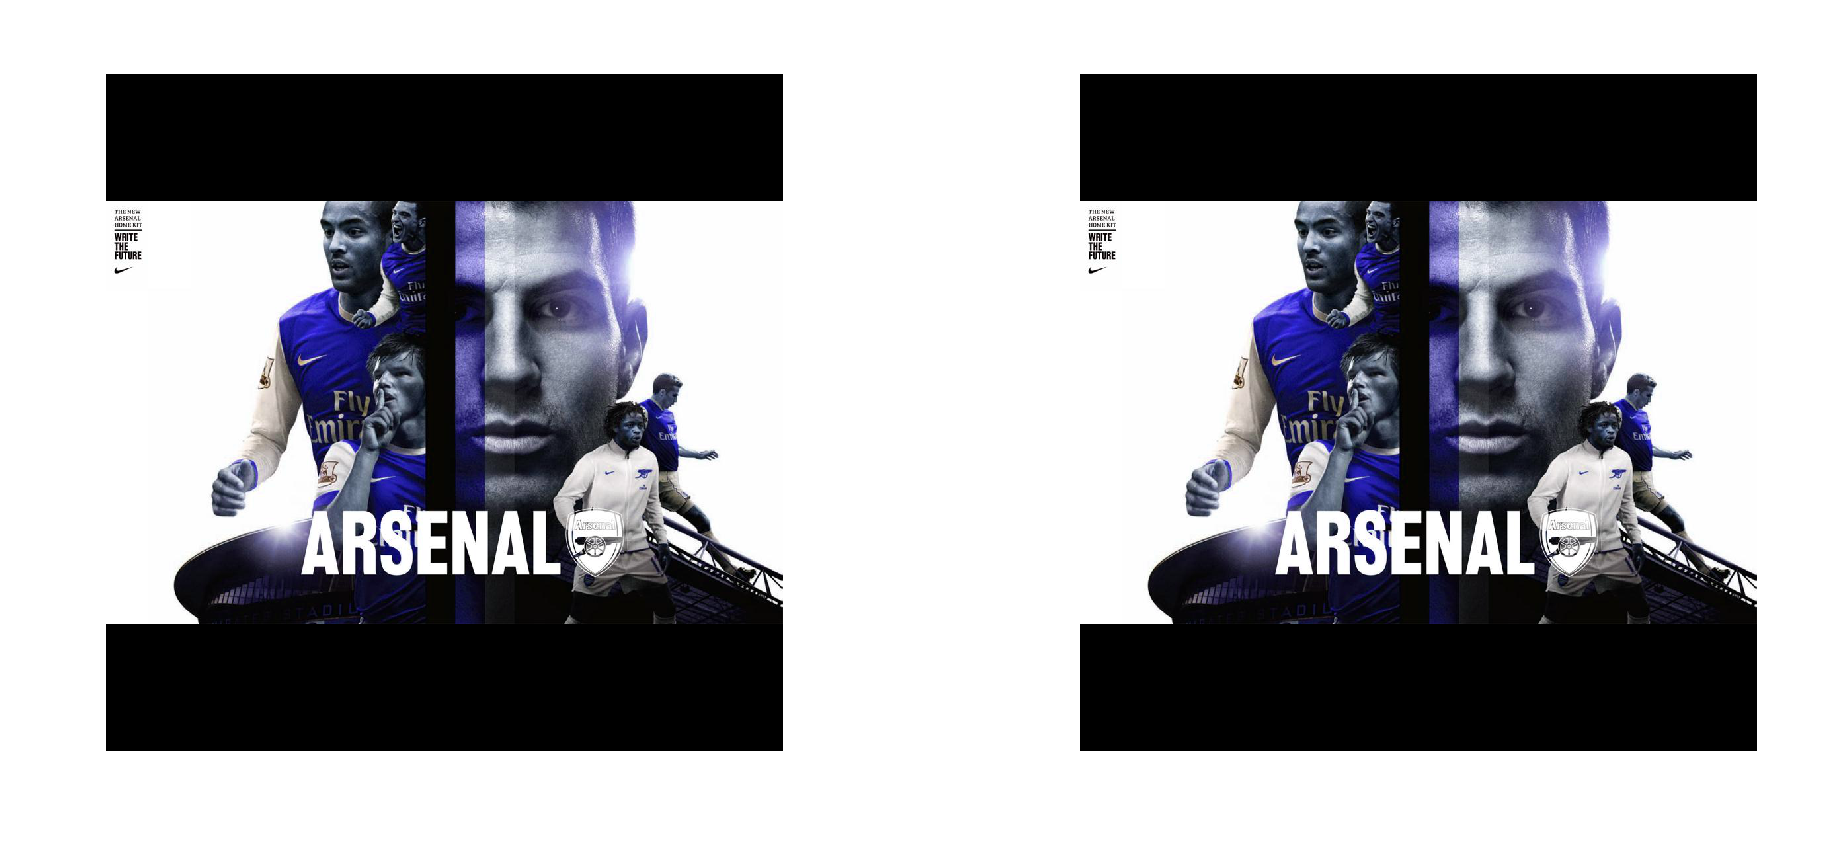

In [19]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
pre_nms_anchors = Utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = Utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = Utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
Visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
Visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

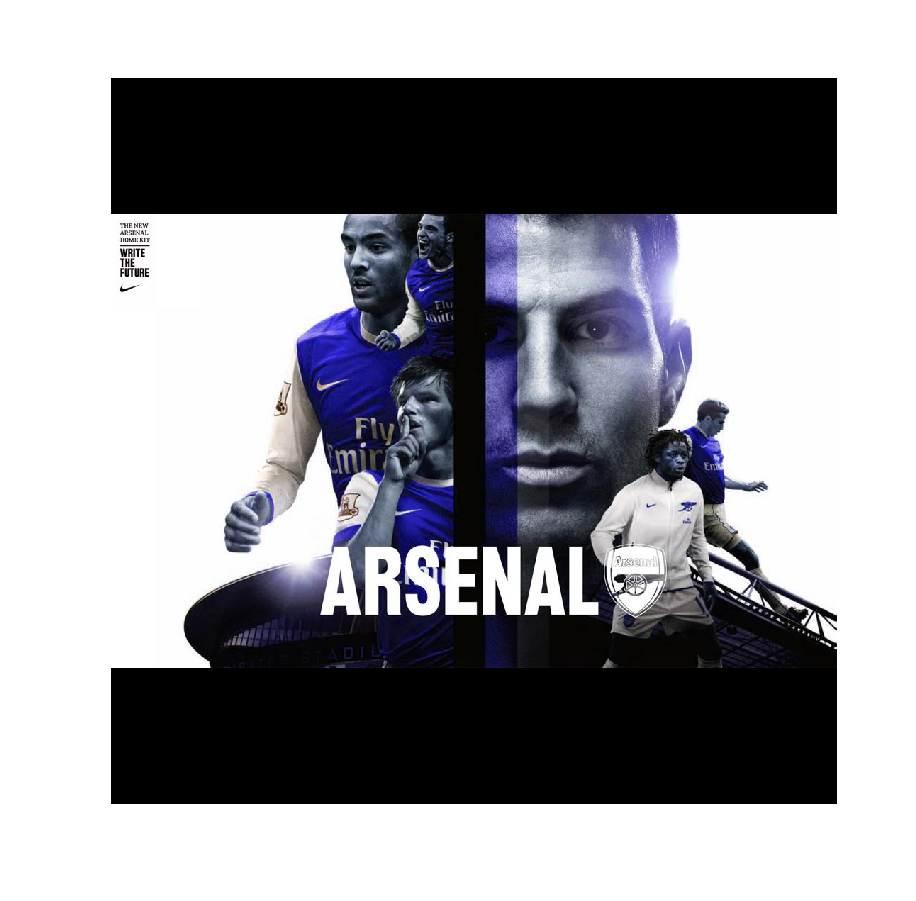

In [20]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
Visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

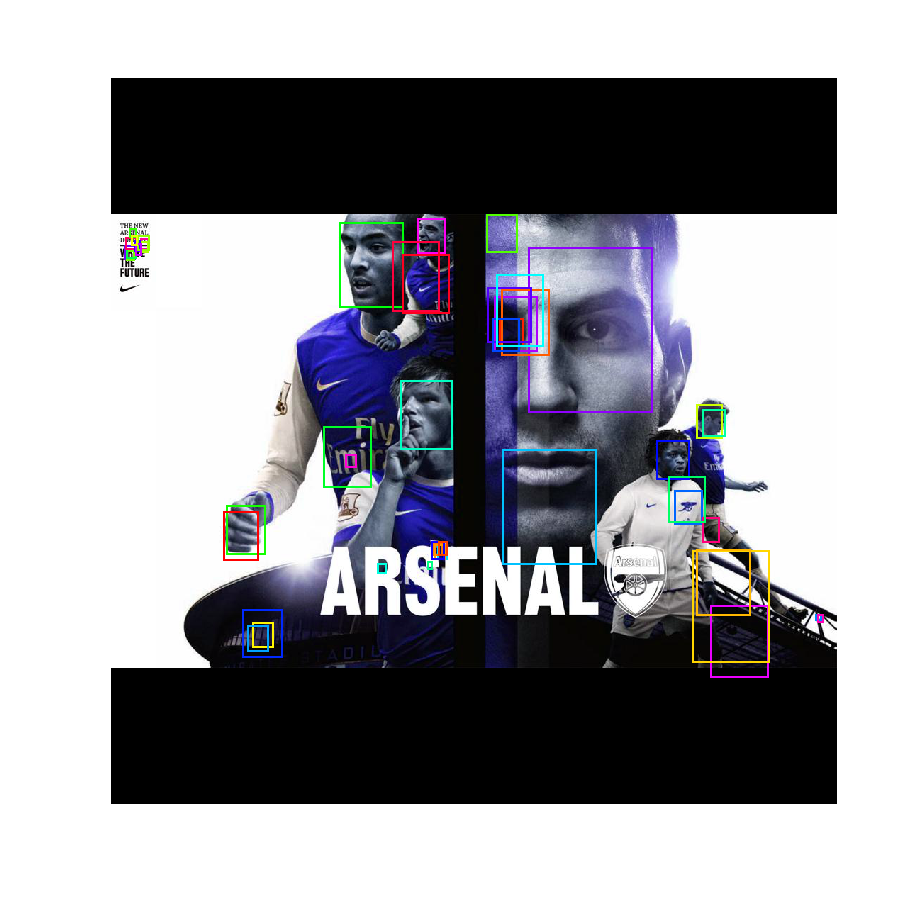

In [21]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
Visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

In [22]:
# Measure the RPN recall (percent of objects covered by anchors)
# Here we measure recall for 3 different methods:
# - All anchors
# - All refined anchors
# - Refined anchors after NMS
iou_threshold = 0.7

recall, positive_anchor_ids = Utils.compute_recall(model.anchors, gt_bbox, iou_threshold)
print("All Anchors ({:5})       Recall: {:.3f}  Positive anchors: {}".format(
    model.anchors.shape[0], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = Utils.compute_recall(rpn['refined_anchors'][0], gt_bbox, iou_threshold)
print("Refined Anchors ({:5})   Recall: {:.3f}  Positive anchors: {}".format(
    rpn['refined_anchors'].shape[1], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = Utils.compute_recall(proposals, gt_bbox, iou_threshold)
print("Post NMS Anchors ({:5})  Recall: {:.3f}  Positive anchors: {}".format(
    proposals.shape[0], recall, len(positive_anchor_ids)))


All Anchors (261888)       Recall: 0.333  Positive anchors: 6
Refined Anchors ( 6000)   Recall: 0.833  Positive anchors: 914
Post NMS Anchors (   50)  Recall: 0.500  Positive anchors: 3


## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [23]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("classify_output").output),
    ("deltas", model.keras_model.get_layer("regr_output").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    0.99572  float32
probs                    shape: (1, 1000, 2)          min:    0.00924  max:    0.99076  float32
deltas                   shape: (1, 1000, 4)          min:   -2.64905  max:    2.71110  float32
detections               shape: (1, 100, 6)           min:    0.00000  max: 1008.00000  float32


In [24]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
Visualize.draw_boxes(
    image, 
    refined_boxes=Utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

3 detections: ['Face' 'Face' 'Face']


ValueError: Image size of 726192x550056 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1152x1152 with 1 Axes>

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [25]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

643 Valid proposals out of 1000
113 Positive ROIs
[('BG', 887), ('Face', 113)]


In [26]:
image.shape

(1024, 1024, 3)

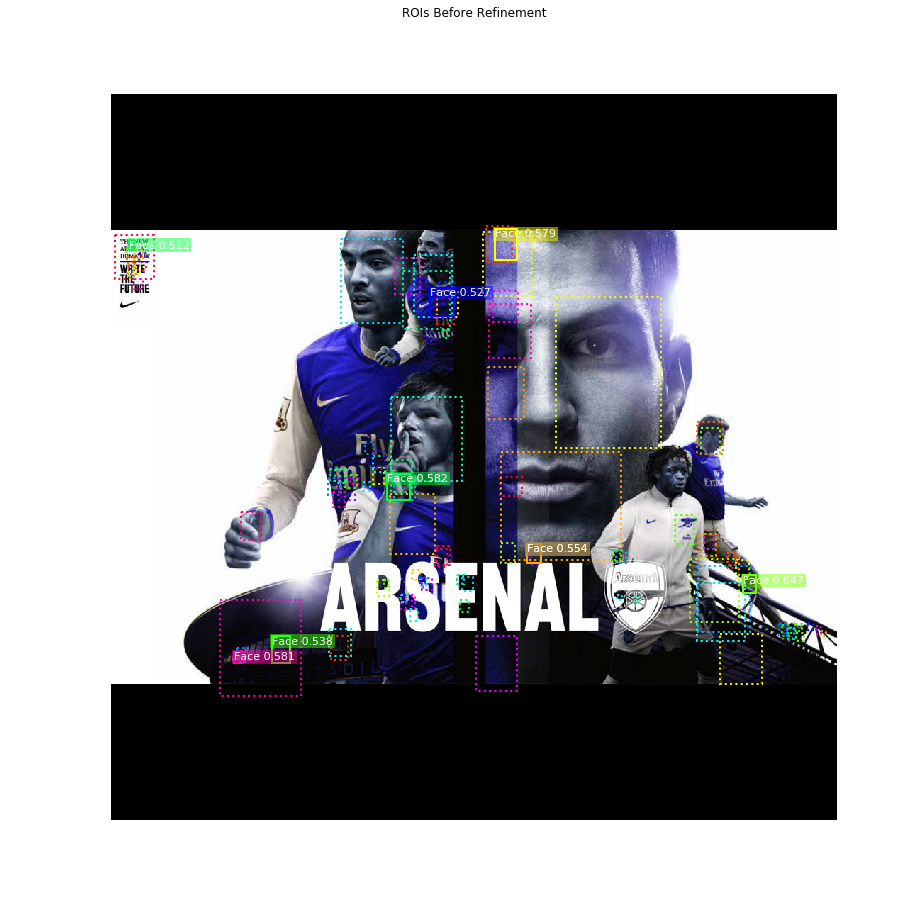

In [27]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
Visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (1000, 4)             min:   -2.64905  max:    2.71110  float32
refined_proposals        shape: (1000, 4)             min:    0.00000  max: 1020.00000  int32


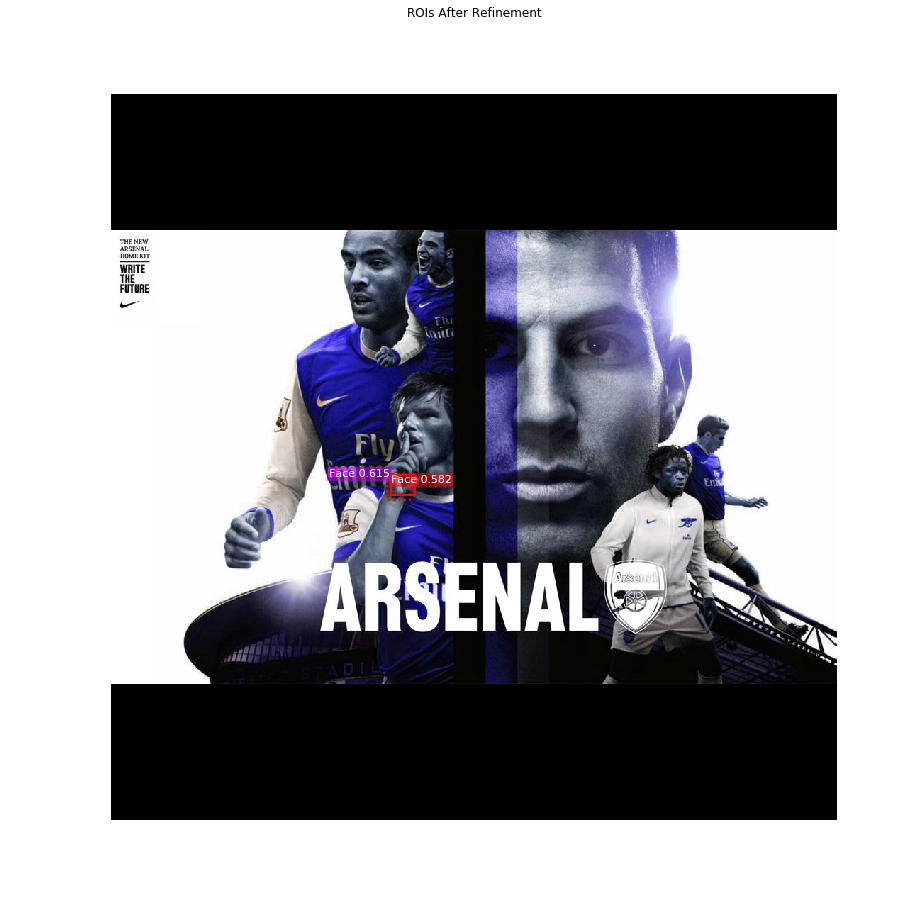

In [28]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0])]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = Utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
Visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [29]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 113 detections:
[ 74  77  97 113 128 130 131 134 150 151 203 208 212 215 225 228 231 239
 264 272 290 293 302 304 307 308 309 311 318 321 322 330 339 340 344 345
 350 361 366 367 368 372 375 389 395 396 411 412 418 422 463 467 468 475
 479 498 531 532 534 535 536 537 538 595 600 615 616 623 629 657 677 685
 687 696 702 703 706 707 711 712 713 714 715 716 718 719 732 739 747 754
 759 762 765 766 782 803 811 830 838 839 855 856 857 860 861 893 914 939
 943 944 948 950 953]


In [30]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.8 confidence. Keep 3:
[212 532 535]


#### Per-Class Non-Max Suppression

In [31]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = Utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

Face                  : [212 532 535] -> [532 535 212]

Kept after per-class NMS: 3
[212 532 535]


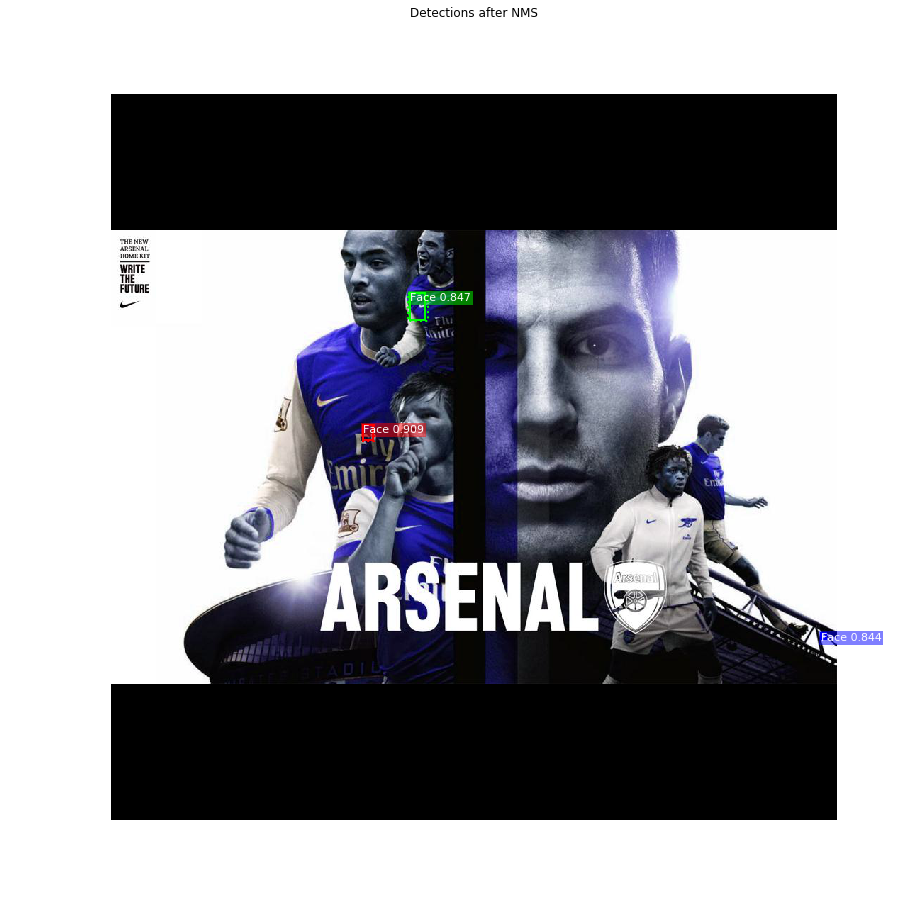

In [32]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
Visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Run Detection

In [33]:
image_id = random.choice(dataset.image_ids)
image_id = 1699
image, image_meta, gt_class_id, gt_bbox =\
    WiderFace.load_image_gt(dataset, config, image_id)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

image ID: Widerface.1699 (1699) 


Processing 1 images


{'rois': array([[687, 924, 703, 935],
        [697,  70, 724,  94],
        [431, 486, 470, 510],
        [518, 339, 590, 398],
        [545,  34, 579,  62],
        [645, 803, 685, 830]]),
 'class_ids': array([1, 1, 1, 1, 1, 1]),
 'scores': array([0.980194  , 0.9467023 , 0.8958794 , 0.88393813, 0.8724805 ,
        0.8094094 ], dtype=float32),
 'rpn_class': array([[[0.9253134 , 0.07468657],
         [0.821584  , 0.17841607],
         [0.99898976, 0.00101023],
         ...,
         [0.9919743 , 0.00802571],
         [0.98925626, 0.01074381],
         [0.9893817 , 0.0106183 ]]], dtype=float32),
 'rpn_bbox': array([[[ 1.0266571 ,  2.3223207 , -5.154931  , -1.7145164 ],
         [ 0.38093755,  1.1637287 , -5.6031876 , -4.9431    ],
         [ 3.314467  ,  1.1321113 , -0.9819795 , -3.8001795 ],
         ...,
         [-1.4627101 , -1.2079003 , -2.124658  , -0.8843892 ],
         [-1.5858489 , -0.37118387, -0.24443781, -1.2069604 ],
         [-1.4740071 , -0.6604256 ,  0.09070781, -1.296312

gt_class_id              shape: (14,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (14, 4)               min:   90.00000  max:  982.00000  float64


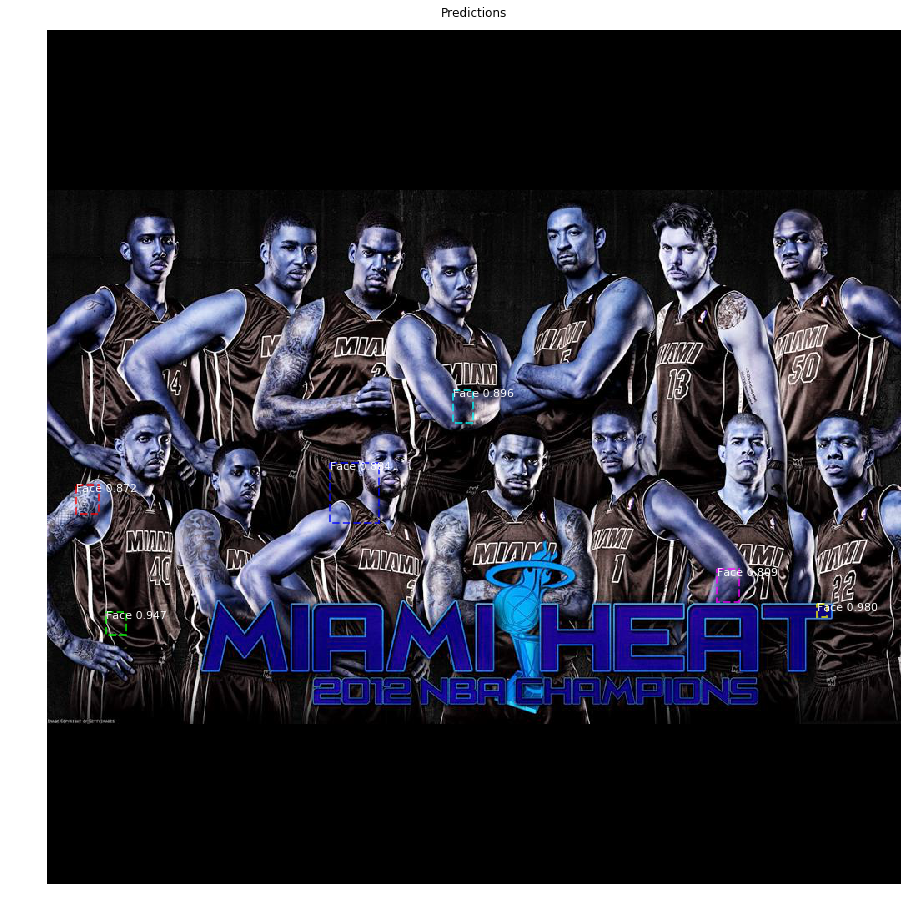

In [34]:
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
display(r)


Visualize.display_instances(image, r['rois'],  None, r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
#log("gt_mask", gt_mask)

### Precision-Recall

In [ ]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = Utils.compute_ap(gt_bbox, gt_class_id, 
                                    r['rois'], r['class_ids'], r['scores'])
Visualize.plot_precision_recall(AP, precisions, recalls)

In [ ]:
# Grid of ground truth objects and their predictions
Visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)

### Compute mAP @ IoU=50 on Batch of Images

In [ ]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox =\
            Data_generator.load_image_gt(dataset, config,
                                   image_id)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            Utils.compute_ap(gt_bbox, gt_class_id,
                              r['rois'], r['class_ids'], r['scores'])
        APs.append(AP)
    return APs

# Pick a set of random images
image_ids = np.random.choice(dataset.image_ids, 10)
APs = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [ ]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

In [ ]:
# Input image (normalized)
_ = plt.imshow(Utils.unmold_image(activations["input_image"][0],config))

In [ ]:
# Backbone feature map
display_images(np.transpose(activations["res4w_out"][0,:,:,:4], [2, 0, 1]))

In [ ]:
# Histograms of RPN bounding box deltas
plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
plt.title("dy")
_ = plt.hist(activations["rpn_bbox"][0,:,0], 50)
plt.subplot(1, 4, 2)
plt.title("dx")
_ = plt.hist(activations["rpn_bbox"][0,:,1], 50)
plt.subplot(1, 4, 3)
plt.title("dw")
_ = plt.hist(activations["rpn_bbox"][0,:,2], 50)
plt.subplot(1, 4, 4)
plt.title("dh")
_ = plt.hist(activations["rpn_bbox"][0,:,3], 50)

In [ ]:
# Distribution of y, x coordinates of generated proposals
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("y1, x1")
plt.scatter(activations["roi"][0,:,0], activations["roi"][0,:,1])
plt.subplot(1, 2, 2)
plt.title("y2, x2")
plt.scatter(activations["roi"][0,:,2], activations["roi"][0,:,3])
plt.show()